### Imports

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
import matplotlib.pyplot as plt

### Load the data

In [ ]:
data = pd.read_csv('new_df.csv')
data = pd.DataFrame(data)

<ipython-input-2-d3c71521113a>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('new_df.csv')


### Shift the target variable

In [ ]:
lag = 3
for i in range(1, lag + 1):
  data[f'pm10-{i}'] = data['pm10'].shift(i)

In [ ]:
data = data.dropna()

In [ ]:
data

,SensorId,Stamp,humidity,pm10,pm25,temperature,Hour,Month_Day_Calculation,pm10-1,pm10-2,pm10-3
3,007f2b03-94e6-47b3-9e3e-44273354acd5,2023-01-01 00:45:00+00:00,85.0,68.0,36.0,4.0,0.75,1.032258,64.0,59.5,55.0
4,007f2b03-94e6-47b3-9e3e-44273354acd5,2023-01-01 01:00:00+00:00,85.0,65.0,32.0,4.0,1.00,1.032258,68.0,64.0,59.5
5,007f2b03-94e6-47b3-9e3e-44273354acd5,2023-01-01 01:15:00+00:00,85.0,54.0,30.0,4.0,1.25,1.032258,65.0,68.0,64.0
6,007f2b03-94e6-47b3-9e3e-44273354acd5,2023-01-01 01:30:00+00:00,86.0,55.0,29.0,3.0,1.50,1.032258,54.0,65.0,68.0
7,007f2b03-94e6-47b3-9e3e-44273354acd5,2023-01-01 01:45:00+00:00,86.0,56.0,30.0,3.0,1.75,1.032258,55.0,54.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
5151135,sensor_dev_84941_208,2024-11-21 22:00:00+00:00,81.0,79.0,34.0,1.0,22.00,11.700000,61.0,76.0,73.0
5151136,sensor_dev_84941_208,2024-11-21 22:15:00+00:00,81.0,47.0,23.0,1.0,22.25,11.700000,79.0,61.0,76.0
5151137,sensor_dev_84941_208,2024-11-21 22:30:00+00:00,81.0,64.0,29.0,1.0,22.50,11.700000,47.0,79.0,61.0
5151138,sensor_dev_84941_208,2024-11-21 22:45:00+00:00,81.0,65.0,30.0,1.0,22.75,11.700000,64.0,47.0,79.0


### Define features and target

In [ ]:
features = ['humidity', 'temperature', 'pm10-1', 'pm10-2', 'pm10-3', 'Hour', 'Month_Day_Calculation']
target = 'pm10'

### Prepare the data

In [ ]:
X = data[features]
y = data[target]

### Scale the features

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Calculate contamination proportion


In [ ]:
z_scores = np.abs(zscore(y))
contamination_proportion = np.sum(z_scores > 3) / len(y)
print(f"Calculated contamination proportion: {contamination_proportion:.4f}")

Calculated contamination proportion: 0.0212


### Isolation Forest

In [ ]:
iso_forest = IsolationForest(contamination=contamination_proportion, random_state=False)
outlier_labels = iso_forest.fit_predict(X_scaled)
data['Outlier_Auto'] = outlier_labels

In [ ]:
print("Outliers:", np.sum(data['Outlier_Auto'] == -1))
print("Inliers:", np.sum(data['Outlier_Auto'] == 1))

Outliers: 70149
Inliers: 3242197


### Visualization

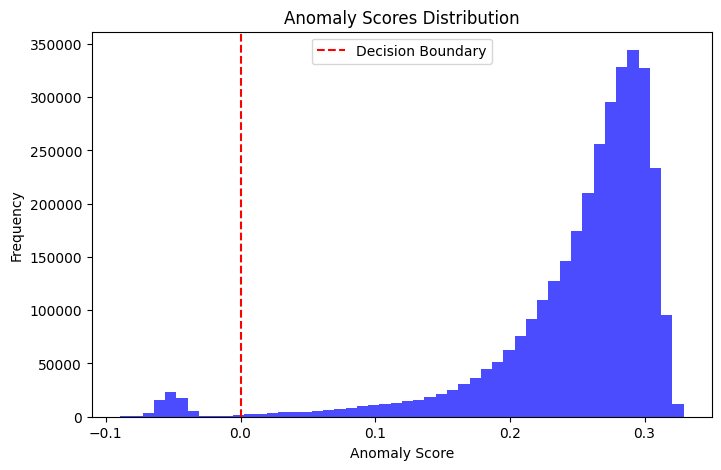

In [ ]:
anomaly_scores = iso_forest.decision_function(X_scaled)
plt.figure(figsize=(8, 5))
plt.hist(anomaly_scores, bins=50, color='blue', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', label='Decision Boundary')
plt.title('Anomaly Scores Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()